### Import required libraries

In [1]:
from warnings import simplefilter
# ignore all future warnings
import warnings
warnings.filterwarnings("ignore")
simplefilter(action='ignore', category=FutureWarning)
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
#from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC

from sklearn.feature_selection import RFECV, RFE
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report,roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer

from statistics import median 
import seaborn as sns
import configparser
import os

%matplotlib inline

### Define file name of configuration and import it

In [2]:
config_fn = 'config.ini'

def parse_list(config_str):
    list_in_param = [x.strip() for x in config_str.split(',')]
    return list_in_param

def parse_dict(config_str):
    removed_nl = config_str.replace('\n', '')
    return eval(removed_nl)

config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']

file_path = config['FileIO']['file_path']
data_path = file_path + config['FileIO']['data_path']
plot_path = file_path + config['FileIO']['plot_path']
result_path = file_path + config['FileIO']['result_path']

out_paths = [plot_path, result_path]
# Create the paths if they don't already exist
for out_path in out_paths:
    if not os.path.exists(out_path):
        print('Created path: ', out_path)
        os.mkdir(out_path)

In [3]:
out_paths

['./readmission/plot/', './readmission/result/']

<a id='preprocessing'></a>
# Data acquisition and pre-processing

In [4]:
# read data file
raw_data_df = pd.read_csv(data_path+config_IO['raw_filename'])
print('Shape of raw data:', raw_data_df.shape)

Shape of raw data: (9229, 42)


### Exclude irrelevant features from the data

In [5]:
# columns_to_drop = parse_list(config['Pre-processing']['columns_to_drop'])
# raw_data_df.drop(columns_to_drop, axis = 1, inplace = True)

### Keep patients who satisfy the conditions defined in the configuration file
In our original article, we only analyzed patients that were confirmed to be positive for COVID-19 based on a PCR test. Similar conditions can be specified for other patient data as well.

In [6]:
filter_column = config['Pre-processing']['keep_only_matched_patient_column']
filter_value = config['Pre-processing']['keep_only_matched_patient_value']

if filter_column != '':
    if filter_column in raw_data_df.columns:
        raw_data_df = raw_data_df[raw_data_df[filter_column] == filter_value]
    else:
        print(filter_column, " is not one of the columns of raw data file")

In [7]:
filter_value

''

In [8]:
raw_data_df_copy = raw_data_df.copy()
raw_data_df_copy

,Death,Age,Gender,BMI,Apache3_score,Blood_presure,Heart_rate,Oxygen_saturation,Myocardial_infarction,Congestive_heart_failure,...,Cardiomyopathy,Heart_failure,Irregular_heartbeat,Cardiac_arrest,Acute_coronary_syndrome,Coronary_artery_disease,Angiogram_hospital_stay,Coronary_stent,SOFA_score,OASIS_score
0,0,54,1,29.681633,41,105,49,99,0,0,...,0,0,0,0,1,0,1,1,3,15
1,0,65,0,18.744796,42,125,85,98,0,0,...,0,0,0,0,0,0,0,0,1,12
2,0,54,1,21.913580,24,188,71,98,0,0,...,0,0,0,0,1,1,1,0,1,15
3,0,59,1,0.000000,34,110,82,99,0,0,...,0,0,0,0,1,1,1,1,1,23
4,0,50,1,22.446126,65,96,70,85,0,1,...,0,1,1,1,0,0,0,0,7,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224,1,72,0,32.656250,65,80,70,97,1,1,...,0,1,1,0,1,1,1,0,3,28
9225,1,65,0,25.383707,71,126,90,97,0,1,...,0,1,1,0,0,1,0,0,5,31
9226,1,66,1,22.305471,180,94,120,75,0,1,...,0,0,0,1,1,1,1,0,15,49
9227,0,56,1,24.772097,89,134,108,95,0,0,...,0,1,0,1,1,1,1,1,8,49


In [9]:
raw_data_df_copy.describe()

,Death,Age,Gender,BMI,Apache3_score,Blood_presure,Heart_rate,Oxygen_saturation,Myocardial_infarction,Congestive_heart_failure,...,Cardiomyopathy,Heart_failure,Irregular_heartbeat,Cardiac_arrest,Acute_coronary_syndrome,Coronary_artery_disease,Angiogram_hospital_stay,Coronary_stent,SOFA_score,OASIS_score
count,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.00000,9229.000000,9229.000000,9229.000000,...,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000,9229.000000
mean,0.082241,67.549247,0.626070,29.548125,61.501571,123.314660,81.94008,95.807888,0.202080,0.198613,...,0.135334,0.388775,0.315527,0.076065,0.429516,0.606350,0.522592,0.349225,4.011702,25.709178
std,0.274746,15.231535,0.483872,7.077341,25.123741,26.215911,23.31713,5.739263,0.401574,0.398978,...,0.342099,0.487498,0.464751,0.265116,0.495034,0.488585,0.499516,0.476751,3.420956,10.340829
min,0.000000,18.000000,0.000000,0.000000,10.000000,50.000000,21.00000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
25%,0.000000,58.000000,0.000000,24.954731,44.000000,105.000000,67.00000,94.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,18.000000
50%,0.000000,69.000000,1.000000,28.437500,58.000000,121.000000,79.00000,97.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,24.000000
75%,0.000000,79.000000,1.000000,33.067867,74.000000,140.000000,94.00000,99.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,6.000000,31.000000
max,1.000000,105.000000,1.000000,75.311634,200.000000,249.000000,283.00000,100.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,65.000000


In [10]:
raw_data_df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9229 entries, 0 to 9228
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Death                         9229 non-null   int64  
 1   Age                           9229 non-null   int64  
 2   Gender                        9229 non-null   int64  
 3   BMI                           9229 non-null   float64
 4   Apache3_score                 9229 non-null   int64  
 5   Blood_presure                 9229 non-null   int64  
 6   Heart_rate                    9229 non-null   int64  
 7   Oxygen_saturation             9229 non-null   int64  
 8   Myocardial_infarction         9229 non-null   int64  
 9   Congestive_heart_failure      9229 non-null   int64  
 10  Cerebro_vascular_accident     9229 non-null   int64  
 11  Kidney_disease_severity       9229 non-null   int64  
 12  Cormorbility_score            9229 non-null   int64  
 13  Dia

### Extract the outcome variable from the dataset, as specified in the configuration file

In [11]:
outcome_col = config['Pre-processing']['outcome_column']
y_raw_df = raw_data_df_copy[outcome_col]
outcome_pos_value = parse_list(config['Pre-processing']['outcome_pos_value'])
outcome_neg_value = parse_list(config['Pre-processing']['outcome_neg_value'])

y_raw_df.replace(outcome_pos_value, 1, inplace=True)
y_raw_df.replace(outcome_neg_value, 0, inplace=True)

In [12]:
columns_to_drop_2 = [outcome_col]
if filter_column != 'None':
    if filter_column in raw_data_df_copy.columns:
        columns_to_drop_2.append(filter_column)
df_dropped_outcome = raw_data_df_copy.drop(columns_to_drop_2,axis = 1)
#print(df_dropped_outcome.info(verbose=True))

In [13]:
df_dropped_outcome

,Age,Gender,BMI,Apache3_score,Blood_presure,Heart_rate,Oxygen_saturation,Myocardial_infarction,Congestive_heart_failure,Cerebro_vascular_accident,...,Cardiomyopathy,Heart_failure,Irregular_heartbeat,Cardiac_arrest,Acute_coronary_syndrome,Coronary_artery_disease,Angiogram_hospital_stay,Coronary_stent,SOFA_score,OASIS_score
0,54,1,29.681633,41,105,49,99,0,0,0,...,0,0,0,0,1,0,1,1,3,15
1,65,0,18.744796,42,125,85,98,0,0,0,...,0,0,0,0,0,0,0,0,1,12
2,54,1,21.913580,24,188,71,98,0,0,0,...,0,0,0,0,1,1,1,0,1,15
3,59,1,0.000000,34,110,82,99,0,0,0,...,0,0,0,0,1,1,1,1,1,23
4,50,1,22.446126,65,96,70,85,0,1,1,...,0,1,1,1,0,0,0,0,7,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9224,72,0,32.656250,65,80,70,97,1,1,1,...,0,1,1,0,1,1,1,0,3,28
9225,65,0,25.383707,71,126,90,97,0,1,0,...,0,1,1,0,0,1,0,0,5,31
9226,66,1,22.305471,180,94,120,75,0,1,0,...,0,0,0,1,1,1,1,0,15,49
9227,56,1,24.772097,89,134,108,95,0,0,0,...,0,1,0,1,1,1,1,1,8,49


### Replace unknown values in the readmission data with NaNs

In [14]:
# replaced unknown value defined in configuration file, eg. ‘unknown’, ‘not asked’, etc with NaN

unknown_value_list = parse_list(config['Pre-processing']['unknown_value'])

for u in unknown_value_list:
    df_dropped_outcome.replace(to_replace=u, value=np.nan, inplace=True)

#### [Only for readmission data, not used for COVID-19 data] 

Map the values from the table defined in `[Pre-processing] value_replacing_dictionary` in the configuration file

In [15]:
value_replaced_dict = parse_dict(config['Pre-processing']['value_replacing_dictionary'])

for k, v in value_replaced_dict.items():
    df_dropped_outcome.replace(to_replace=k, value=v, inplace=True)

### Perform label encoding for categorical features/variables

In [16]:
df_dropped_outcome_obj = df_dropped_outcome.select_dtypes([np.int64, np.float64]).copy()
#print(df_dropped_outcome_obj)
'''df_dropped_outcome_obj = df_dropped_outcome.select_dtypes(include=['int']).copy()
dfTmp = df_dropped_outcome_obj
mask = dfTmp.isnull()
dfTmp = dfTmp.astype(str).apply(LabelEncoder().fit_transform)
df_LE = dfTmp.where(~mask, df_dropped_outcome_obj)'''
df_LE = df_dropped_outcome_obj

In [17]:
df_dropped_obj = df_dropped_outcome.drop(df_LE.columns.tolist(), axis = 1)
df_final = pd.concat([df_dropped_obj,df_LE], axis = 1)

### Remove features which have more than 99% constant values

In [18]:
df_features_constants = pd.DataFrame({'features':df_final.sum().index.tolist(),'values':df_final.sum().values.tolist()})
df_dropped_features_constants = df_final[df_features_constants[df_features_constants['values'] > df_final.shape[0]*0.01].features.tolist()]
X_df = df_final[df_dropped_features_constants.columns.tolist()]

### Split pre-processed data into development and test sets in an 80:20 ratio

As in our original COVID-19 study, the following code creates and processes a development set to train and evaluate candidate classifiers, and a first test set to evaluate the final classifier obtained from the whole development set. 


In [19]:
development_features, test_features, development_labels, test_labels = train_test_split(X_df,y_raw_df,test_size=0.2,stratify = y_raw_df, random_state=64)


### Export development and test sets to csv files

In [20]:
development_features.to_csv(data_path+config_IO['df_development'],index=False)
development_labels.to_csv(data_path+config_IO['y_development'],index=False)
test_features.to_csv(data_path+config_IO['df_test'],index=False)
test_labels.to_csv(data_path+config_IO['y_test'],index=False)
print('Finished pre-processing!')

Finished pre-processing!


<a id='missing_value_imputation'></a>
# Missing value imputation process
Import the development set along with its respective  outcome values, and carry out analyses to identify the optimal missing value level.

In [21]:


df_development = pd.read_csv(data_path + config_IO['df_development'])
y_development = pd.read_csv(data_path + config_IO['y_development'])

### Transform the continuous features first

In [22]:
continous_feature = parse_list(config['Continuous_feature']['continuous_feature'])
X_development_cont = df_development[continous_feature]

### Scale all continuous features into z-scores (standard scaling)

In [23]:
ss = StandardScaler()
development_features_ss = pd.DataFrame(ss.fit_transform(X_development_cont), columns =  X_development_cont.columns.tolist())

### Select categorical features

In [24]:
columns = X_development_cont.columns.tolist()
X_development_cate_miss = df_development.drop(columns,axis =1)
categorical_feature = X_development_cate_miss.columns.tolist()

### Concatenate transformed continuous and categorical features

In [25]:
df_development_scaled = pd.concat([development_features_ss, X_development_cate_miss], axis=1)

### Find highly correlated/collinear features (>0.90)

In [26]:
# Create correlation matrix
corr_matrix = df_development_scaled.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

### Drop the highly correlated features from the dataframe, since they may be redundant

In [27]:
df_development_scaled_dropped =  df_development_scaled.drop(to_drop , axis=1 )
if len(to_drop) == 0:
    print('None of the columns is dropped due to highly correlated features/columns.')
else:
    print('Column(s) being dropped due to their high correlation(s) with other features/columns:')
    print(to_drop)

None of the columns is dropped due to highly correlated features/columns.


In [28]:
# Construct an array of the labels/outcomes of the development set
y_development_np = y_development.values

#### Function for getting prediction scores from different classifiers

In [29]:
def proba_score(est_model, feat):
    if hasattr(est_model, "predict_proba"):
        y_1 = est_model.predict_proba(feat)[:,1]
        y_0 = est_model.predict_proba(feat)[:,0]
    else:  # use decision function
        prob_pos = est_model.decision_function(feat)
        y_1 = prob_pos
        y_0 = -1*prob_pos
        
    return y_1, y_0

### Repeat missing value imputation 100 times and assess average performance at different missing value levels
In the following block of code, the development dataset is randomly split into a 75% subset for training classifiers after imputation and a 25% subset for performance evaluation. Multiple classifiers are trained after dropping features missing in more than a certain percentage (from 0% to 60% in steps of 5%). Performance of the resultant classifiers is measured in terms of the AUC score.

This process is repeated 100 times (see for loop below), and the results are stored in csv files for further analysis and visualization


In [30]:

# Creating Scores Container

performance_dict_final = {}
dict_clf = {'rf': RandomForestClassifier(),
            'lr': LogisticRegression(), 
            'svm': LinearSVC(), 
           }

list_measure = ['AUC']

for c, c_class in dict_clf.items():
    performance_dict_final[c] = {}
    for m in list_measure:
        performance_dict_final[c][m] = []

missing_percentages = range(0,61,5)


for i in range(0, 51):
    print("===>", i)
    train_features, holdout_features, train_labels, holdout_labels = train_test_split(df_development_scaled_dropped,
                                                                              y_development_np,test_size=0.25,
                                                                              stratify = y_development_np)   
    if (i % 10 == 0) and (i != 0):
        print('Running {}th imputation measurement...'.format(i))
    
    performance_dict = {}
    for c, c_class in dict_clf.items():
        performance_dict[c] = {}
        for m in list_measure:
            performance_dict[c][m] = []
        
    for j in missing_percentages:# (0,61,5)
        
        # drop features (columns) with missing values in 0,5,10,15,20,25....,60% of the patients
        train_features_cutoff = train_features[train_features.columns[(train_features.isna().mean().round(4) * 100 <=j)].tolist()]
        holdout_features_cutoff = holdout_features[train_features.columns[(train_features.isna().mean().round(4) * 100 <=j)].tolist()]

        # select the continuous features of the training and holdout sets
        train_features_cont = train_features_cutoff[list(set(train_features_cutoff.columns.tolist()) & set(continous_feature))]
        holdout_features_cont = holdout_features_cutoff[list(set(holdout_features_cutoff.columns.tolist()) & set(continous_feature))]

        # select the categorical features of the training and holdout sets
        train_features_cate = train_features_cutoff[list(set(train_features_cutoff.columns.tolist()) & set(categorical_feature))]
        holdout_features_cate = holdout_features_cutoff[list(set(holdout_features_cutoff.columns.tolist()) & set(categorical_feature))]
    
        # Missing values of the continuous features are imputed with the mean of their respective available values
        my_imputer = SimpleImputer(strategy = 'mean')
        imputed_train_features_cont = pd.DataFrame(my_imputer.fit_transform(train_features_cont),columns =train_features_cont.columns.tolist())
        imputed_holdout_features_cont = pd.DataFrame(my_imputer.transform(holdout_features_cont),columns =holdout_features_cont.columns.tolist())

        # Missing values of the categorical features are imputed with the mode of their respective available values
        my_imputer_mf = SimpleImputer(strategy = "most_frequent")
        imputed_X_train_cate = pd.DataFrame(my_imputer_mf.fit_transform(train_features_cate),columns = train_features_cate.columns.tolist())
        imputed_X_holdout_cate = pd.DataFrame(my_imputer_mf.transform(holdout_features_cate),columns = holdout_features_cate.columns.tolist())

        # concatenate all continuous and categorical features after imputation
        train_features_final = pd.concat([imputed_train_features_cont,imputed_X_train_cate], axis=1)
        holdout_features_final = pd.concat([imputed_holdout_features_cont,imputed_X_holdout_cate], axis=1)

        
        # Training and evaluating classifiers at different missing value levels
        for clf_key, clf_var in dict_clf.items():
            clf_var.fit(train_features_final, train_labels)
            y_pred = clf_var.predict(holdout_features_final)

            y_score, y_score_0 = proba_score(clf_var, holdout_features_final)

            fpr, tpr, th = metrics.roc_curve(holdout_labels, y_score, pos_label = 1)
            auc_roc = metrics.auc(fpr, tpr)  


            score_list_of_clf = [auc_roc]

            for m_idx, m in enumerate(list_measure):
                performance_dict[clf_key][m].append(score_list_of_clf[m_idx])

        
    
    for c, c_class in dict_clf.items():
        for m in list_measure:
            performance_dict_final[c][m].append(performance_dict[c][m])

print('Done!')

===> 0
===> 1
===> 2
===> 3
===> 4
===> 5
===> 6
===> 7
===> 8
===> 9
===> 10
Running 10th imputation measurement...
===> 11
===> 12
===> 13
===> 14
===> 15
===> 16
===> 17
===> 18
===> 19
===> 20
Running 20th imputation measurement...
===> 21
===> 22
===> 23
===> 24
===> 25
===> 26
===> 27
===> 28
===> 29
===> 30
Running 30th imputation measurement...
===> 31
===> 32
===> 33
===> 34
===> 35
===> 36
===> 37
===> 38
===> 39
===> 40
Running 40th imputation measurement...
===> 41
===> 42
===> 43
===> 44
===> 45
===> 46
===> 47
===> 48
===> 49
===> 50
Running 50th imputation measurement...
Done!


### Save the results of missing value imputation

In [31]:
missing_percentage_columns = ['{}%'.format(int(p)) for p in missing_percentages]

for c, c_class in dict_clf.items():
    for m in list_measure:
        df_temp = pd.DataFrame(performance_dict_final[c][m], columns=missing_percentage_columns)
        df_temp.to_csv(result_path+'df_{}_{}.csv'.format(m, c), index=False)

print('Finished saving results of imputation!')

Finished saving results of imputation!


<a id='figure2a'></a>
### Generate a figure summarizing the results of the missing value imputation process

This code generates the missing value imputation results such as those shown in Figure 2A in the paper.

In [32]:
df_AUC_rf = pd.read_csv(result_path+'df_AUC_rf.csv')
df_AUC_lr = pd.read_csv(result_path+'df_AUC_lr.csv')
df_AUC_svm = pd.read_csv(result_path+'df_AUC_svm.csv')
#df_AUC_xgb = pd.read_csv(result_path+'df_AUC_xgb.csv')

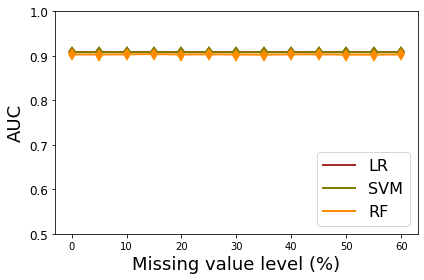

In [33]:
plt.figure(figsize=(6,4))
import numpy as np
import matplotlib.pyplot as plt

#plt.subplot(325)
x = missing_percentages

RF_auc = df_AUC_rf.mean()
RF_auc_etd_er = df_AUC_rf.sem(axis = 0)
LR_auc = df_AUC_lr.mean()
LR_auc_etd_er = df_AUC_lr.sem(axis = 0)
SVM_auc = df_AUC_svm.mean()
SVM_auc_etd_er = df_AUC_svm.sem(axis = 0)
#XGB_auc = df_AUC_xgb.mean()
#XGB_auc_etd_er = df_AUC_xgb.sem(axis = 0)

#plt.plot(x, XGB_auc,'b-',label='XGB',linewidth=2,markersize = 10)
#plt.errorbar(x, XGB_auc, yerr=XGB_auc_etd_er, fmt='',linestyle='None', ecolor='b', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, LR_auc,'-',color ='brown',label='LR',linewidth=2,markersize = 10)
plt.errorbar(x, LR_auc, yerr=LR_auc_etd_er, fmt='',linestyle='None', ecolor='brown',linewidth=2, capthick=2, uplims=True, lolims=True)

plt.plot(x, SVM_auc,'-',color ='olive',label='SVM',linewidth=2,markersize = 10)
plt.errorbar(x, SVM_auc, yerr=SVM_auc_etd_er, fmt='',linestyle='None', ecolor='olive', linewidth=2,capthick=2, uplims=True, lolims=True)

plt.plot(x, RF_auc,'-',color = 'darkorange',label='RF',linewidth=2,markersize = 10)
plt.errorbar(x, RF_auc, yerr=RF_auc_etd_er, fmt='',linestyle='None', ecolor='darkorange',linewidth=2, capthick=2,uplims=True, lolims=True)

plt.xlabel('Missing value level (%)', fontsize=18)
# plt.xticks(np.arange(0, 61, step=5),fontsize=12)
plt.yticks( fontsize=12)
plt.ylabel('AUC', fontsize=18)
plt.ylim([0.50,1.00])
plt.legend(('LR', 'SVM','RF'), loc='lower right', fontsize=16)

plt.tight_layout()
# save the figure in tiff file
#plt.savefig(plot_path+"Figure_2A.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})

From the resultant Figure 2A in our article, we found that the 20% missing value level yielded the most accurate prediction, and hence, we dropped any features with >20% missing values.

Based on the results in the above plot, the user can set the value of the `missing_value_level` code variable to that at which the performance is maximized. Based on the results in the above plot for the readmission dataset, which doesn’t show much variation, we are setting this value to 20, as we did in the original COVID-19 article. This variable, and its value, will be used in further analyses.

In [34]:
missing_value_level = 20

# Feature selection using recursive feature elimination (RFE)


RFE is a feature selection method, which automatically selects a subset of features with potentially better performance than all the features. The following code implements the various parts of the process used in our study. 

In [35]:
# Again import the development data set, include the features with acceptable missing value levels, 
# and prepare it for RFE experiments using the same pre-processing steps implemented above.
config = configparser.ConfigParser()
config.read(config_fn)
config_IO = config['FileIO']

df_development = pd.read_csv(data_path+config_IO['df_development'])
y_development = pd.read_csv(data_path+config_IO['y_development'])

In [36]:
df_development_dropped_missed  = df_development[df_development.columns[(df_development.isna().mean().round(4) * 100 <= missing_value_level)].tolist()]
print('The dimension of data after filtering:', df_development_dropped_missed.shape)

The dimension of data after filtering: (7383, 41)


In [37]:
# Impute features in the development set that satisfied the best missing value level determined in the above code block

X_development_cont = df_development_dropped_missed[list(set(continous_feature)&set(df_development_dropped_missed.columns.tolist()))]

# Impute continuous features with the mean of their respective available values using the SimpleImputer library
my_imputer = SimpleImputer(strategy = 'mean')
imputed_X_development_cont = pd.DataFrame(my_imputer.fit_transform(X_development_cont), columns = X_development_cont.columns.tolist())

# Normalize the continuous features into z-scores using the StandardScaler  library
ss = StandardScaler()
development_features_ss = pd.DataFrame(ss.fit_transform(imputed_X_development_cont), columns =  imputed_X_development_cont.columns.tolist())

# Drop continuous variables from the dataframe to select categorical variables
columns = X_development_cont.columns.tolist()
X_cate_miss = df_development_dropped_missed.drop(columns,axis =1)

# Impute missing values in categorical features using the mode of their respective available values
my_imputer_mf = SimpleImputer(strategy = "most_frequent")
imputed_X_development_cate = pd.DataFrame(my_imputer_mf.fit_transform(X_cate_miss),columns = X_cate_miss.columns.tolist())

# Concatenate the resultant continuous and categorical features after imputation
df_development_imputed = pd.concat([development_features_ss,imputed_X_development_cate], axis=1)

# Finding highly correlated features (>0.90) among the revised set of features
# Create correlation matrix
corr_matrix = df_development_imputed.corr().abs()
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

# Drop highly correlated features from datafram
df_development_imputed_dropped_high_corr =  df_development_imputed.drop(to_drop , axis=1 )


### Repeat the RFE-based feature selection process 100 times
In the following block of code, the development dataset is split into a 75% subset for selecting features and training candidate classifiers, and a 25% subset for evaluating these classifiers. This process is repeated 100 times (see the second “for” loop below), and the results stored into csv files for further analysis and visualization. Performance is measured in terms of the AUC score, and all the relevant statistics are stored at the end of the code block. We start with basic settings for the RFE analysis.

In [38]:
total_num_feat = df_development_imputed_dropped_high_corr.shape[1]
print('Total number of features = ', total_num_feat)    

Total number of features =  41


The `step_size` variable below can be set to determine the list of the number of features that should be tested in this analysis. For readmission data, we set the value of this variable to 5.

In [39]:
step_size = 5
no_features_to_pick_list = np.array(range(1,total_num_feat+1, step_size))
if not total_num_feat in no_features_to_pick_list:
    no_features_to_pick_list = np.append(no_features_to_pick_list, [total_num_feat])
    
print('The list of number of subset features we would like to test:')
print(no_features_to_pick_list)

The list of number of subset features we would like to test:
[ 1  6 11 16 21 26 31 36 41]


Note that this code, and the following, code can be modified to pre-specify the number of features to be tested (instead of step size), as we did in our original COVID-19 study.

The following code block implements the RFE-based feature selection process, combined with the four classification algorithms used in our original study, and stores all the results for further analysis and visualization.

In [40]:
feature_df = df_development_imputed_dropped_high_corr

feature_np_array = feature_df.values
set_of_seed = range(51)
outcome_np_array = y_development_np


total_feature = feature_df.shape[1]
feature_name_list = list(feature_df.columns.values)
estimator_dict = {
            #'XGBoost': XGBClassifier(),
            'LR': LogisticRegression(),
            'SVM': LinearSVC(),
            'RF': RandomForestClassifier()
}


# Container of the RFE results
all_result_df_list = []

result_df = pd.DataFrame(columns=['seed', 'classifier', 'num_features_picked', 'AUC'] + feature_name_list)
result_col = result_df.columns

result_container = dict()


# Iterating over classification algorithms
for est_name, est in estimator_dict.items():
    auc_mean_list = []
    auc_se_list = []
    # This for loop generates the training-holdout splits of the development set to evaluate the above algorithms 
    # with different feature subsets
    for random_seed in set_of_seed:
        if (random_seed % 20 == 0) and (random_seed != 0):
            print('{}th round of {} training is running...'.format(random_seed, est_name))
        train_features, holdout_features, train_labels, holdout_labels = train_test_split(
            feature_df, outcome_np_array, test_size=0.25, stratify = outcome_np_array)
        est_var = est
        selector = RFE(estimator=est_var, step=1, n_features_to_select=1)
        selector = selector.fit(train_features, train_labels)
        rank_f = selector.ranking_

        for n_f in no_features_to_pick_list:

            selected_feat = rank_f <= n_f
            est_var = est
            est_var.fit(train_features.iloc[:,selected_feat], train_labels)
            if hasattr(est_var, "predict_proba"):
                prob_pos = est_var.predict_proba(holdout_features.iloc[:,selected_feat])[:,1]
            else:  # use decision function
                prob_pos = est_var.decision_function(holdout_features.iloc[:,selected_feat])
            auc = roc_auc_score(holdout_labels, prob_pos)
            dict_to_append = {'seed': random_seed, 'classifier': est_name, 'num_features_picked': n_f, 'AUC': auc}

            for idx, f_name in enumerate(feature_name_list):
                dict_to_append[f_name] = selected_feat[idx]
            result_df = result_df.append(dict_to_append, ignore_index=True)

    
all_result_df_list.append(result_df)



20th round of LR training is running...
40th round of LR training is running...
20th round of SVM training is running...
40th round of SVM training is running...
20th round of RF training is running...
40th round of RF training is running...


In [41]:
all_result_df = pd.concat(all_result_df_list)
# save results in a csv file
all_result_df.to_csv(result_path+'RFE_result.csv')
print('Feature selection results saved.')

Feature selection results saved.


### Generate a figure summarizing the AUC scores of the four classification algorithms with subsets of features selected by RFE
This code generates the feature selection results such as those shown in Figure 2B in the paper.  Specifically, this figure plots how the performance of the tested classification algorithms varies with the different number of features tested in this feature selection process.

Done!


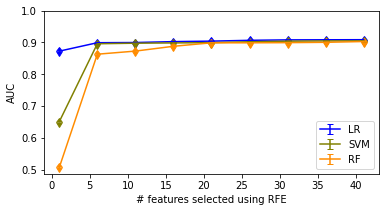

In [42]:
fig = plt.figure(figsize=(6,3))
ax = fig.add_subplot(111)
bar_color_list = ['b', 'olive', 'darkorange']
for est_idx , (est_name, est) in enumerate(estimator_dict.items()):
    auc_mean_list = []
    auc_se_list = []
    for n_f in no_features_to_pick_list:
        auc_array = all_result_df.loc[(all_result_df['classifier'] == est_name) & (all_result_df['num_features_picked'] == n_f), 'AUC'].values
        auc_mean = np.mean(auc_array)
        auc_se = np.std(auc_array)/np.sqrt(len(auc_array))

        auc_mean_list.append(auc_mean)
        auc_se_list.append(auc_se)
    ax.errorbar(x=no_features_to_pick_list, y=auc_mean_list, yerr=auc_se_list, label=est_name, 
                color=bar_color_list[est_idx], uplims=True, lolims=True)
ax.legend()
ax.set_ylabel('AUC')
ax.set_xlabel('# features selected using RFE')
ax.set_ylim([None,1.00])
#fig.savefig(plot_path+"Figure_2B.tiff", dpi=600, format="tiff", pil_kwargs={"compression": "tiff_lzw"})


print('Done!')

Based on the result in the above plot, they can set the value of `top_N` to the number of features they would like to include (N) in the final classifier. Based on the results in the above plot for the readmission dataset, we are setting this value to 6.

In [43]:
top_N = 6


### Visualizing the top N features selected by RFE in 100 runs
This code block analyzes the results of the RFE process above to identify the top_N features for the four classification algorithms, and visualize them as a bar chart like in Figure 4A in our original COVID-19 article.

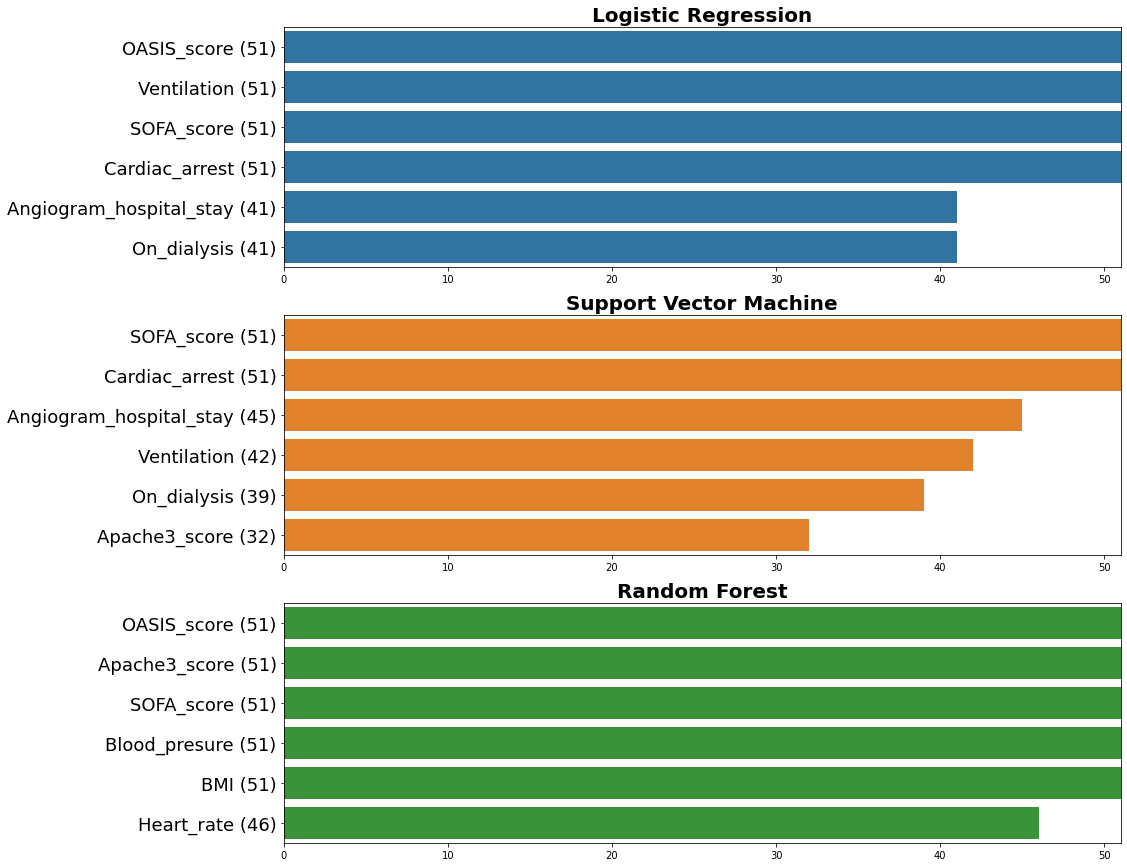

In [44]:
estimator_dict = {
            #'XGBoost': XGBClassifier,
            'LR': LogisticRegression,
            'SVM': LinearSVC,
            'RF': RandomForestClassifier
}
cp = sns.color_palette(n_colors=len(estimator_dict))
all_result_df = pd.read_csv(result_path+'RFE_result.csv')
feature_name_list = list(df_development_imputed_dropped_high_corr.columns.values)
estimator_full_name_dict = {#'XGBoost': 'XGBoost',
            'LR': 'Logistic Regression',
            'SVM': 'Support Vector Machine',
            'RF': 'Random Forest'}

set_of_seed = [range(51)]

# Code for bar plot
top_n_list = [top_N]
bar_color_list = ['b', 'olive', 'darkorange']
for top_n in top_n_list:
    top_n_df = all_result_df[all_result_df['num_features_picked'] == top_n]
    freq_df_list = []
    freq_df = pd.DataFrame(columns=['set_to_run', 'classifier', 'freq', 'feature'])
    feature_frequency_dict_by_clf = dict()
    fig2, axs = plt.subplots(3, figsize=(15,15))
    top_n_df_by_seed_set = top_n_df
    for est_idx, (est_name, est) in enumerate(estimator_dict.items()):
        top_n_df_by_clf = top_n_df_by_seed_set[top_n_df_by_seed_set['classifier']==est_name]

        for idx, f_name in enumerate(feature_name_list):
            freq = sum(top_n_df_by_clf[f_name].values)
            dict_to_append = {'classifier': est_name,
                              'freq': freq, 'feature': f_name}
            freq_df = freq_df.append(dict_to_append, ignore_index=True)


        freq_df_est = freq_df[freq_df['classifier']==est_name]
        freq_df_est = freq_df_est.sort_values(by=['freq'], ascending=False).iloc[:top_n]
        axs[est_idx] = sns.barplot(ax=axs[est_idx], x="freq", y="feature", data=freq_df_est, orient='h', color=cp[est_idx])

        axs[est_idx].set_yticks(range(top_n))
        axs[est_idx].set_title(estimator_full_name_dict[est_name], fontweight='bold',fontsize = 20)
        axs[est_idx].set_xlim([0, set_of_seed[-1][-1]+1])
        axs[est_idx].set_xlabel('')
        new_yticks_label = []
        axs[est_idx].set_ylabel('')
        for idx, yticks in enumerate(axs[est_idx].get_yticklabels()):
            new_yticks_label.append("{} ({})".format(yticks.get_text(), freq_df_est['freq'].iloc[idx]))
        axs[est_idx].set_yticklabels(new_yticks_label, fontsize=18)
   # fig2.savefig(plot_path+'Figure_4A_top{}_frequency_by_clf.tif'.format(top_n), 
                 #bbox_inches="tight", dpi=600, pil_kwargs={"compression": "tiff_lzw"})


# Final Selected Features

1. Age
2. Sex
3. pneumonia

While other three features will be dropped and converted into new features for the Regression part.